FINE TUNING ON  COMBINED DATASET (FaceForensics++, SythASpoof and ReplayAttck )

In [1]:
!pip install -q tensorflow tensorflow-addons ffmpeg-python opencv-python-headless numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
#Delete all the existing contents of Output directory
import shutil
import os

working_dir = '/kaggle/working'

# Loop through all items and remove them
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
    except Exception as e:
        print(f'Failed to delete {item_path}. Reason: {e}')

print("All contents of /kaggle/working have been deleted.")

All contents of /kaggle/working have been deleted.


In [3]:
#  Consolidate the 3 datasets (with sampling) into /kaggle/working/dataset3/{real,fake}

import os
import glob
import shutil
import random

# 1. Paths to your three input roots
SYNTH_ROOT  = '/kaggle/input/synthaspoof/SynthASpoof/SynthASpoof'
ROSE_ROOT   = '/kaggle/input/rose-frames/kaggle/working/frames'
REPLAY_ROOT = '/kaggle/input/frames-replay-attack'

# 2. Destination
DST_ROOT = '/kaggle/working/dataset3'
REAL_DIR = os.path.join(DST_ROOT, 'real')
FAKE_DIR = os.path.join(DST_ROOT, 'fake')
os.makedirs(REAL_DIR, exist_ok=True)
os.makedirs(FAKE_DIR, exist_ok=True)

# 3. Utility to copy a list of files with prefix
def copy_list(fps, dst_dir, prefix=""):
    for fp in fps:
        fname = os.path.basename(fp)
        dst = os.path.join(dst_dir, prefix + fname)
        shutil.copy2(fp, dst)

# Fix seed for reproducibility
random.seed(42)

# 4. SYNTHASPOOF
# 4a) BonaFide → real (sample 50%)
bf_paths = glob.glob(os.path.join(SYNTH_ROOT, 'BonaFide', '*.*'))
sample_bf = random.sample(bf_paths, k=len(bf_paths)//2)
copy_list(sample_bf, REAL_DIR, prefix='synth_BonaFide_')

# 4b) PAs/* → fake (sample 50% from each subfolder)
pa_root = os.path.join(SYNTH_ROOT, 'PAs')
for sub in os.listdir(pa_root):
    subdir = os.path.join(pa_root, sub)
    if os.path.isdir(subdir):
        pa_paths = glob.glob(os.path.join(subdir, '*.*'))
        sample_pa = random.sample(pa_paths, k=len(pa_paths)//2)
        copy_list(sample_pa, FAKE_DIR, prefix=f'synth_PA_{sub}_')

# 5. ROSE‑frames
# 5a) real → real (sample 50%)
rose_real = glob.glob(os.path.join(ROSE_ROOT, 'real', '*.*'))
sample_rr = random.sample(rose_real, k=len(rose_real)//2)
copy_list(sample_rr, REAL_DIR, prefix='rose_real_')

# 5b) fake → fake (sample 50%)
rose_fake = glob.glob(os.path.join(ROSE_ROOT, 'fake', '*.*'))
sample_rf = random.sample(rose_fake, k=len(rose_fake)//2)
copy_list(sample_rf, FAKE_DIR, prefix='rose_fake_')

# 6. FRAMES‑REPLAY‑ATTACK (take ALL)
# 6a) real → real
replay_real = glob.glob(os.path.join(REPLAY_ROOT, 'real', '*.*'))
copy_list(replay_real, REAL_DIR, prefix='replay_real_')

# 6b) fake → fake
replay_fake = glob.glob(os.path.join(REPLAY_ROOT, 'fake', '*.*'))
copy_list(replay_fake, FAKE_DIR, prefix='replay_fake_')

# 7. Summary
print(f"TOTAL REAL count: {len(os.listdir(REAL_DIR))}")
print(f"TOTAL FAKE count: {len(os.listdir(FAKE_DIR))}")

TOTAL REAL count: 21105
TOTAL FAKE count: 53669


In [4]:
#Split the combined dataset 
import os
import glob
import random
import shutil

# 1. Configuration
SRC_ROOT   = '/kaggle/working/dataset3'
DST_ROOT   = '/kaggle/working/dataset3_split'
CLASSES    = ['real','fake']
RATIOS     = (0.7, 0.15, 0.15)  # train, val, test
SEED       = 42

random.seed(SEED)

# 2. Create destination directories
for split in ['train','val','test']:
    for cls in CLASSES:
        os.makedirs(os.path.join(DST_ROOT, split, cls), exist_ok=True)

# 3. Split each class
for cls in CLASSES:
    src_dir = os.path.join(SRC_ROOT, cls)
    files   = sorted(glob.glob(os.path.join(src_dir, '*.*')))
    random.shuffle(files)
    
    n = len(files)
    n_train = int(n * RATIOS[0])
    n_val   = int(n * (RATIOS[0] + RATIOS[1]))
    
    splits = {
        'train': files[:n_train],
        'val':   files[n_train:n_val],
        'test':  files[n_val:]
    }
    
    # 4. Copy into each split folder
    for split, fps in splits.items():
        dst_dir = os.path.join(DST_ROOT, split, cls)
        for fp in fps:
            fname = os.path.basename(fp)
            shutil.copy2(fp, os.path.join(dst_dir, fname))

# 5. Report counts
for split in ['train','val','test']:
    for cls in CLASSES:
        cnt = len(os.listdir(os.path.join(DST_ROOT, split, cls)))
        print(f"{split}/{cls}: {cnt} images")

train/real: 14773 images
train/fake: 37568 images
val/real: 3166 images
val/fake: 8050 images
test/real: 3166 images
test/fake: 8051 images


In [5]:
# #Downlaod the test dataset for future testing 
# !zip -r /kaggle/working/test.zip /kaggle/working/dataset3_split/test
# from IPython.display import FileLink
# FileLink('/kaggle/working/test.zip')

In [10]:
# Cell 2: Model Training & Periodic Saving with Focal Loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, callbacks
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# 1. Configuration
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 128
EPOCH_HEAD  = 5
EPOCH_FINE  = 30    # total fine‑tune epochs
CLASS_NAMES = ['real', 'fake']
DATA_DIR    = '/kaggle/working/dataset3_split'

# 2. tf.data pipelines
def build_ds(split, augment=False):
    ds = keras.utils.image_dataset_from_directory(
        os.path.join(DATA_DIR, split),
        labels='inferred', label_mode='categorical',
        class_names=CLASS_NAMES,
        image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=(split == 'train'), seed=42
    )
    ds = ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    if augment and split == 'train':
        aug = keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.05),
            layers.RandomContrast(0.2),
        ])
        ds = ds.map(lambda x, y: (aug(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = build_ds('train', augment=True)
val_ds   = build_ds('val')
test_ds  = build_ds('test')

Found 52341 files belonging to 2 classes.
Found 11216 files belonging to 2 classes.
Found 11217 files belonging to 2 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks, applications

# 3. Model definition
base = applications.EfficientNetB0(
    input_shape=(*IMG_SIZE, 3), include_top=False,
    weights='imagenet', pooling='avg'
)
base.trainable = False

inp = keras.Input(shape=(*IMG_SIZE, 3))
x   = base(inp, training=False)
x   = layers.Dropout(0.3)(x)
out = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)
model = keras.Model(inputs=inp, outputs=out)

# 4. Custom callback to save every N epochs in .keras format
class SaveEveryNEpoch(callbacks.Callback):
    def __init__(self, n, prefix="EB0_all_e"):
        super().__init__()
        self.n = n
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            ep = epoch + 1
            keras_path = f"{self.prefix}{ep}.keras"
            # save full model in the native Keras format
            self.model.save(keras_path)
            print(f"\n→ Saved checkpoint: {keras_path}\n")

# 5. Callbacks
cbs = [
    callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2),
    callbacks.EarlyStopping(monitor='val_auc', patience=4, restore_best_weights=True),
    SaveEveryNEpoch(n=10, prefix="EB0_all_e"),
    # Save the best full model (not just weights) in .keras format
    callbacks.ModelCheckpoint(
        "video_model_latest.keras",
        save_weights_only=False,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

# 6. Stage 1: train head only
focal_loss = keras.losses.CategoricalFocalCrossentropy(
    alpha=0.25, gamma=2.0, from_logits=False
)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=focal_loss,
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)
model.fit(train_ds, validation_data=val_ds,
          epochs=EPOCH_HEAD, callbacks=cbs)

# 7. Stage 2: fine-tune backbone
base.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=focal_loss,
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)
model.fit(train_ds, validation_data=val_ds,
          epochs=EPOCH_FINE, callbacks=cbs)

# 8. Final evaluation
loss, acc, auc = model.evaluate(test_ds, verbose=2)
print(f"Test → loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")

# 9. Confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_true, axis=1)

cm   = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Test Confusion Matrix")
plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
158/409 ━━━━━━━━━━━━━━━━━━━━ 2:08 511ms/step - accuracy: 0.6728 - auc: 0.7008 - loss: 0.0411

In [ ]:
# #Download the combined dataset
# !zip -r /kaggle/working/dataset3_split.zip /kaggle/working/dataset3_split

In [ ]:
model.save('/kaggle/working/EB0_all_v2.keras')
model.save('/kaggle/working/EB0_all_v2.h5')

Found 11217 files belonging to 2 classes.


I0000 00:00:1748318177.578926     111 service.cc:148] XLA service 0x7fba88003d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748318177.580037     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748318177.580051     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748318179.618563     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748318189.476676     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 - 38s - 436ms/step - accuracy: 0.7497 - auc: 0.8340 - loss: 1.1076
Test → loss: 1.1076, acc: 0.7497, auc: 0.8340
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step


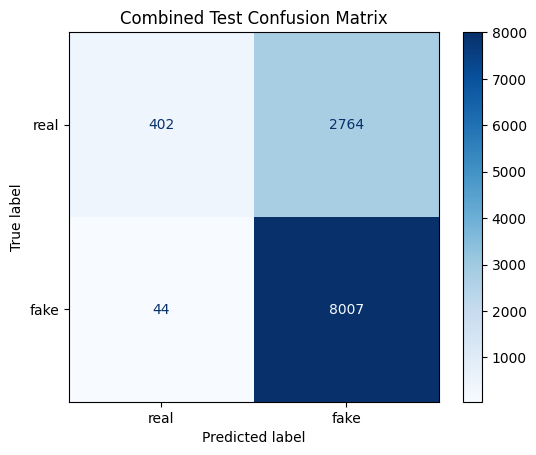

In [7]:
# 8. Final evaluation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load and compile model
model = load_model('/kaggle/working/EB0_all_v2.h5', compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', AUC()])

# Load test dataset
test_ds = build_ds('/kaggle/working/dataset3_split/test')

# Evaluate
loss, acc, auc = model.evaluate(test_ds, verbose=2)
print(f"Test → loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")

# Generate confusion matrix
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
preds = model.predict(test_ds)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Test Confusion Matrix")
plt.show()


In [ ]:
# #Delete a particular contents of Output directory
# import shutil
# import os

# working_dir = '/kaggle/working/dataset3'

# # Loop through all items and remove them
# for item in os.listdir(working_dir):
#     item_path = os.path.join(working_dir, item)
#     try:
#         if os.path.isfile(item_path) or os.path.islink(item_path):
#             os.remove(item_path)
#         elif os.path.isdir(item_path):
#             shutil.rmtree(item_path)
#     except Exception as e:
#         print(f'Failed to delete {item_path}. Reason: {e}')

# print(f"All contents of {working_dir} have been deleted.")